In [3]:
import os
import sys
import nltk
import rich
import torch
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from dotenv   import load_dotenv
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from transformers  import AutoTokenizer, AutoConfig
from scipy.special import softmax
from sklearn.metrics  import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [4]:
# Load DATA_PATH from .env file
load_dotenv()
data_path  = os.getenv("DATA_PATH")
model_path = os.getenv("MODEL_PATH")
cebab_path = os.getenv("CEBAB_PATH")

In [6]:
# Load the datasets
df_rnd_not = pd.read_csv(data_path+"/goemo_samples_1000_rnd_not.csv")
df_syn_not = pd.read_csv(data_path+"/goemo_samples_1000_syn_not.csv")
df_adj_rpl = pd.read_csv(data_path+"/goemo_samples_1000_adj_replace.csv")

## sentiment score comparison

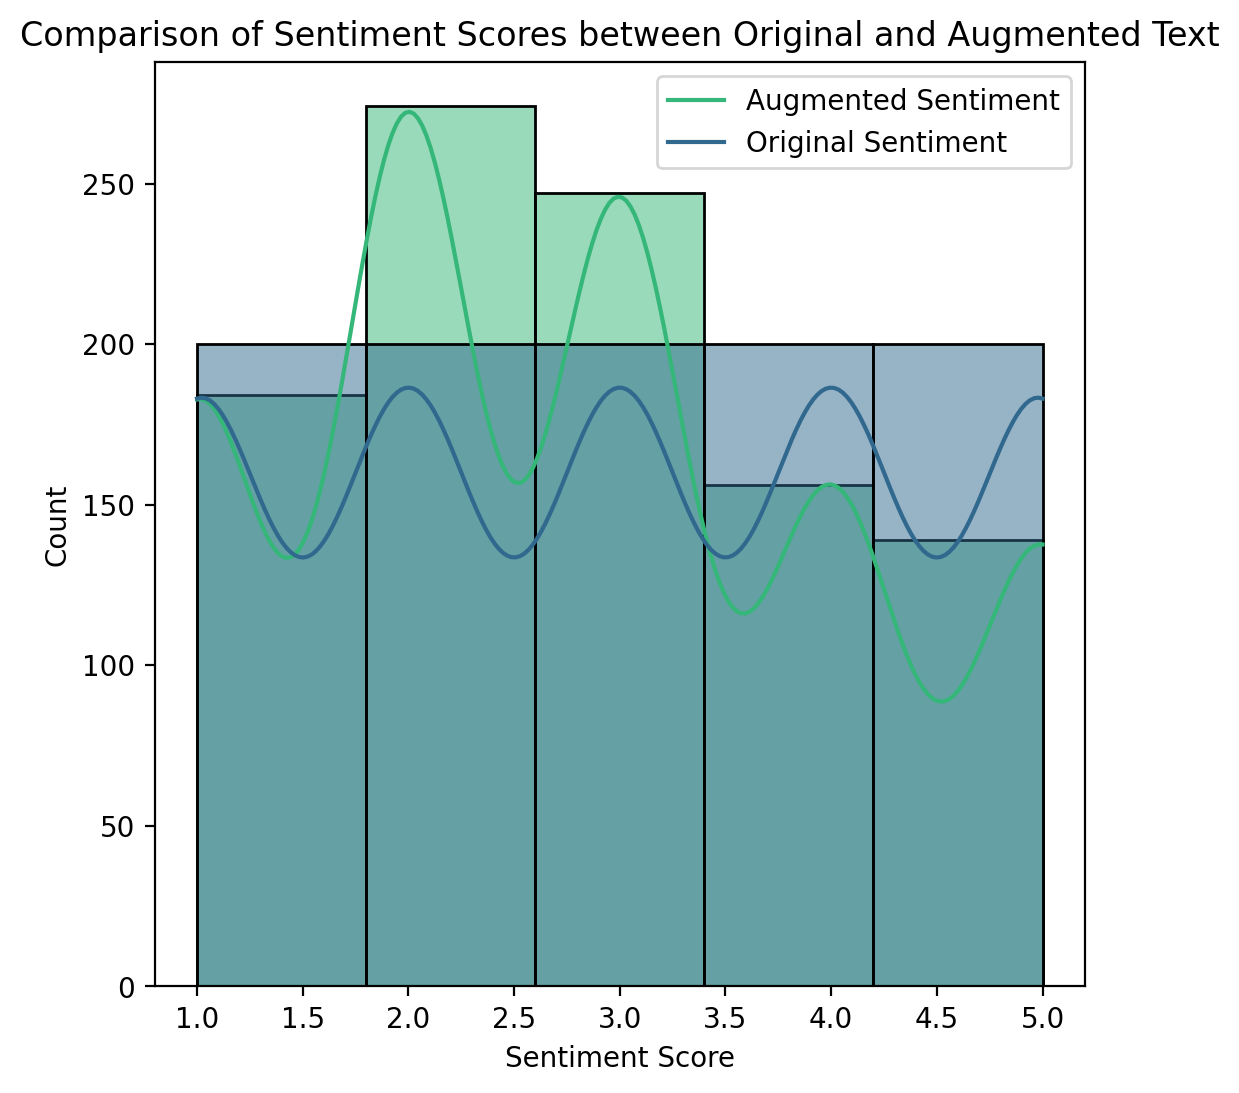

In [4]:
# Plot sentiment score comparison
plt.figure(figsize=(6, 6),dpi=200)
sns.histplot(df_rnd_not[['predicted_sentiment', 'augmented_sentiment']], kde=True, palette="viridis", bins=5)
plt.title('Comparison of Sentiment Scores between Original and Augmented Text')
plt.xlabel('Sentiment Score')
plt.legend(['Augmented Sentiment', 'Original Sentiment', ])
plt.show()

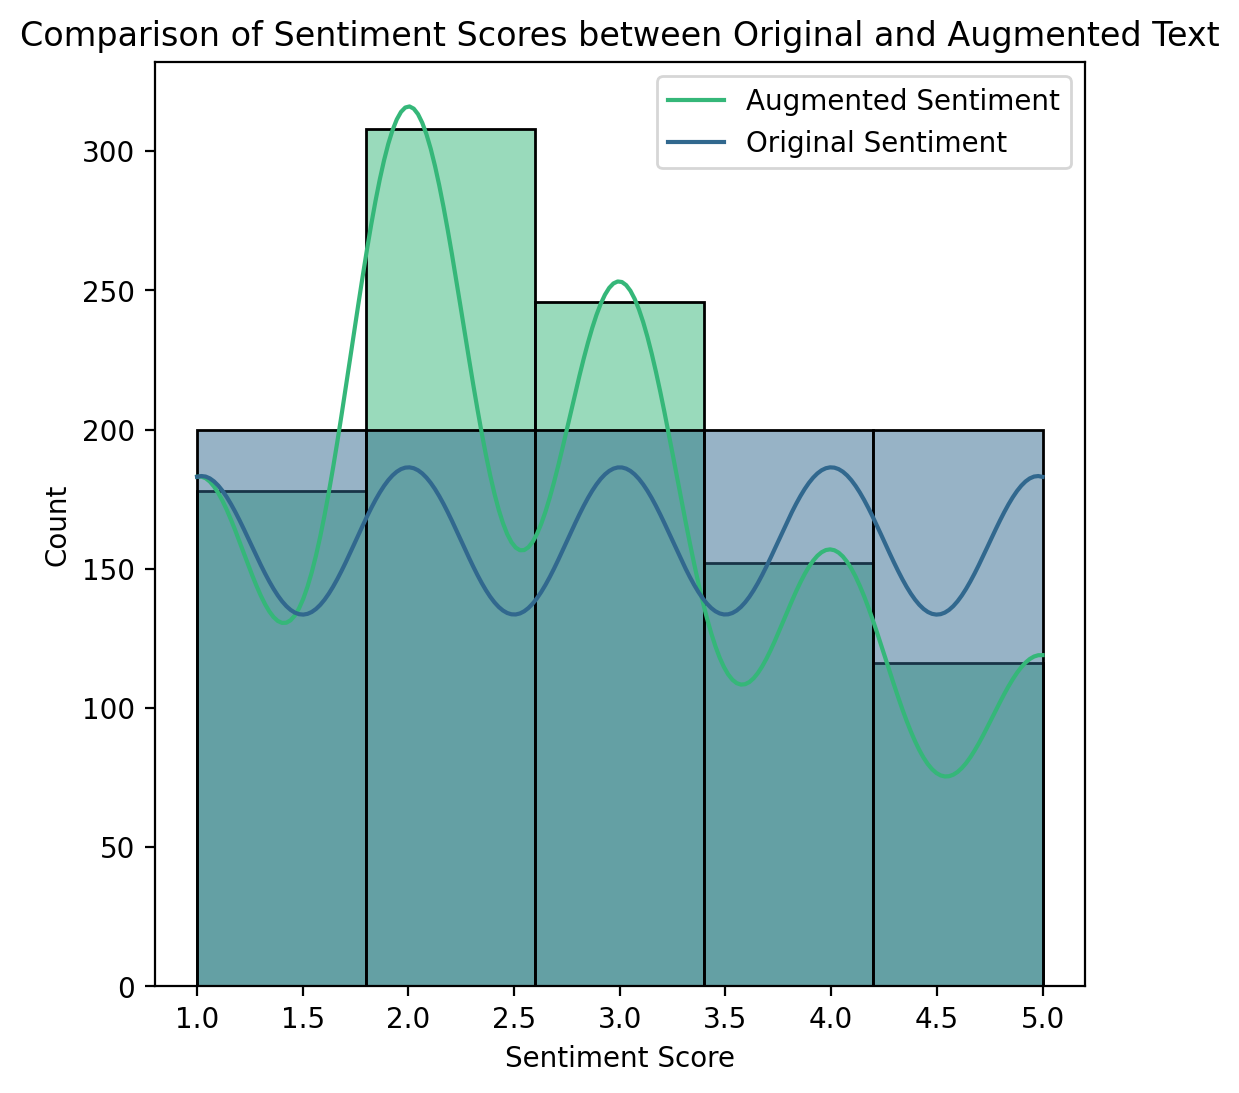

In [5]:
# Plot sentiment score comparison
plt.figure(figsize=(6, 6),dpi=200)
sns.histplot(df_syn_not[['predicted_sentiment', 'augmented_sentiment']], kde=True, palette="viridis", bins=5)
plt.title('Comparison of Sentiment Scores between Original and Augmented Text')
plt.xlabel('Sentiment Score')
plt.legend(['Augmented Sentiment', 'Original Sentiment', ])
plt.show()

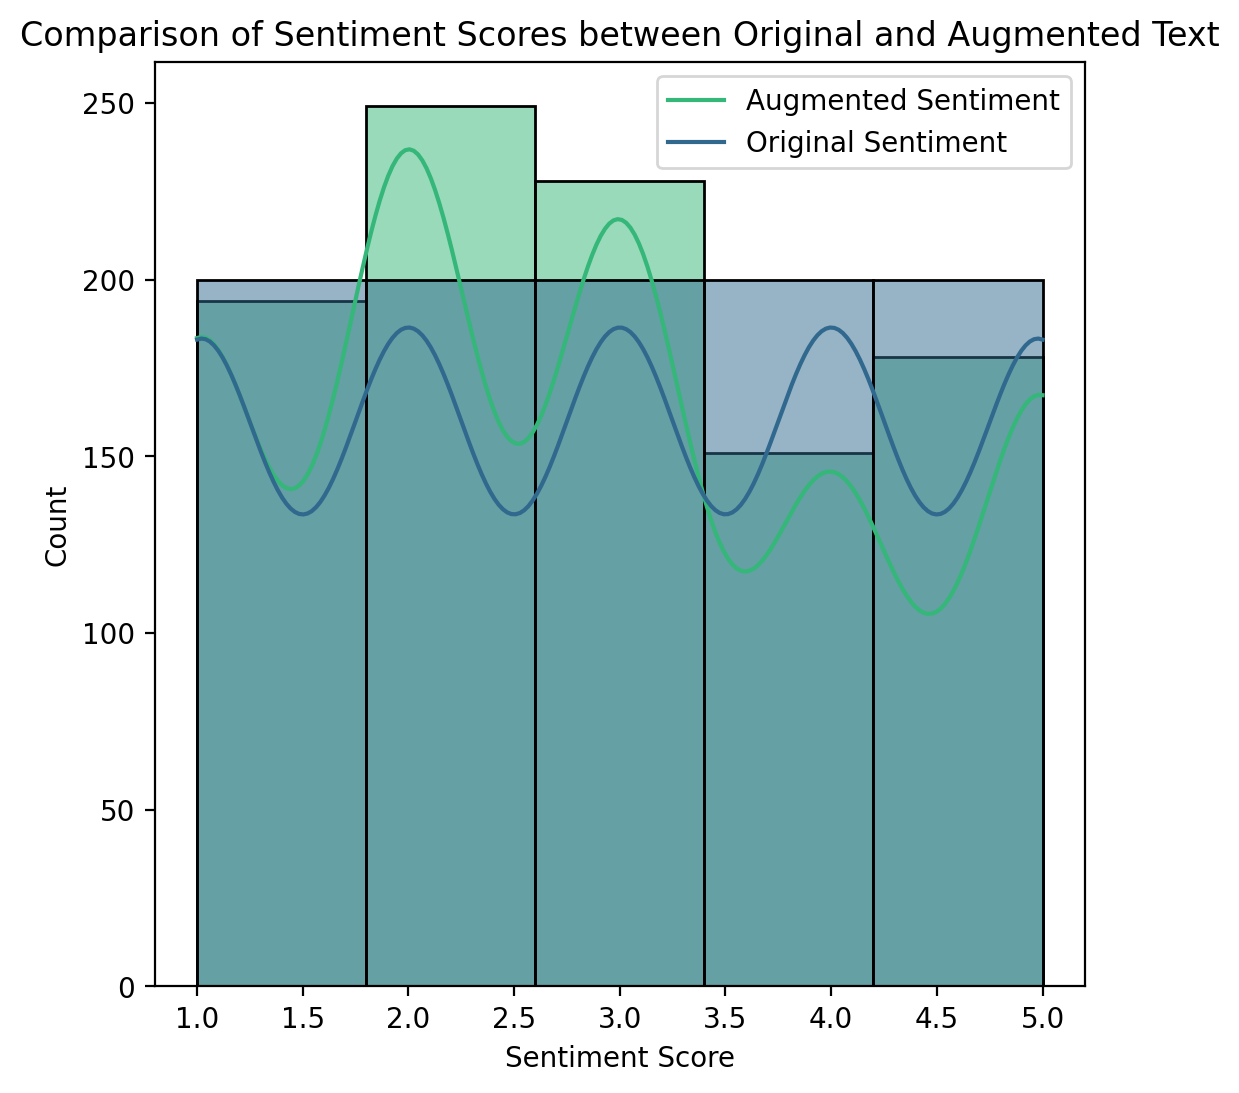

In [6]:
# Plot sentiment score comparison
plt.figure(figsize=(6, 6),dpi=200)
sns.histplot(df_adj_rpl[['predicted_sentiment', 'augmented_sentiment']], kde=True, palette="viridis", bins=5)
plt.title('Comparison of Sentiment Scores between Original and Augmented Text')
plt.xlabel('Sentiment Score')
plt.legend(['Augmented Sentiment', 'Original Sentiment', ])
plt.show()

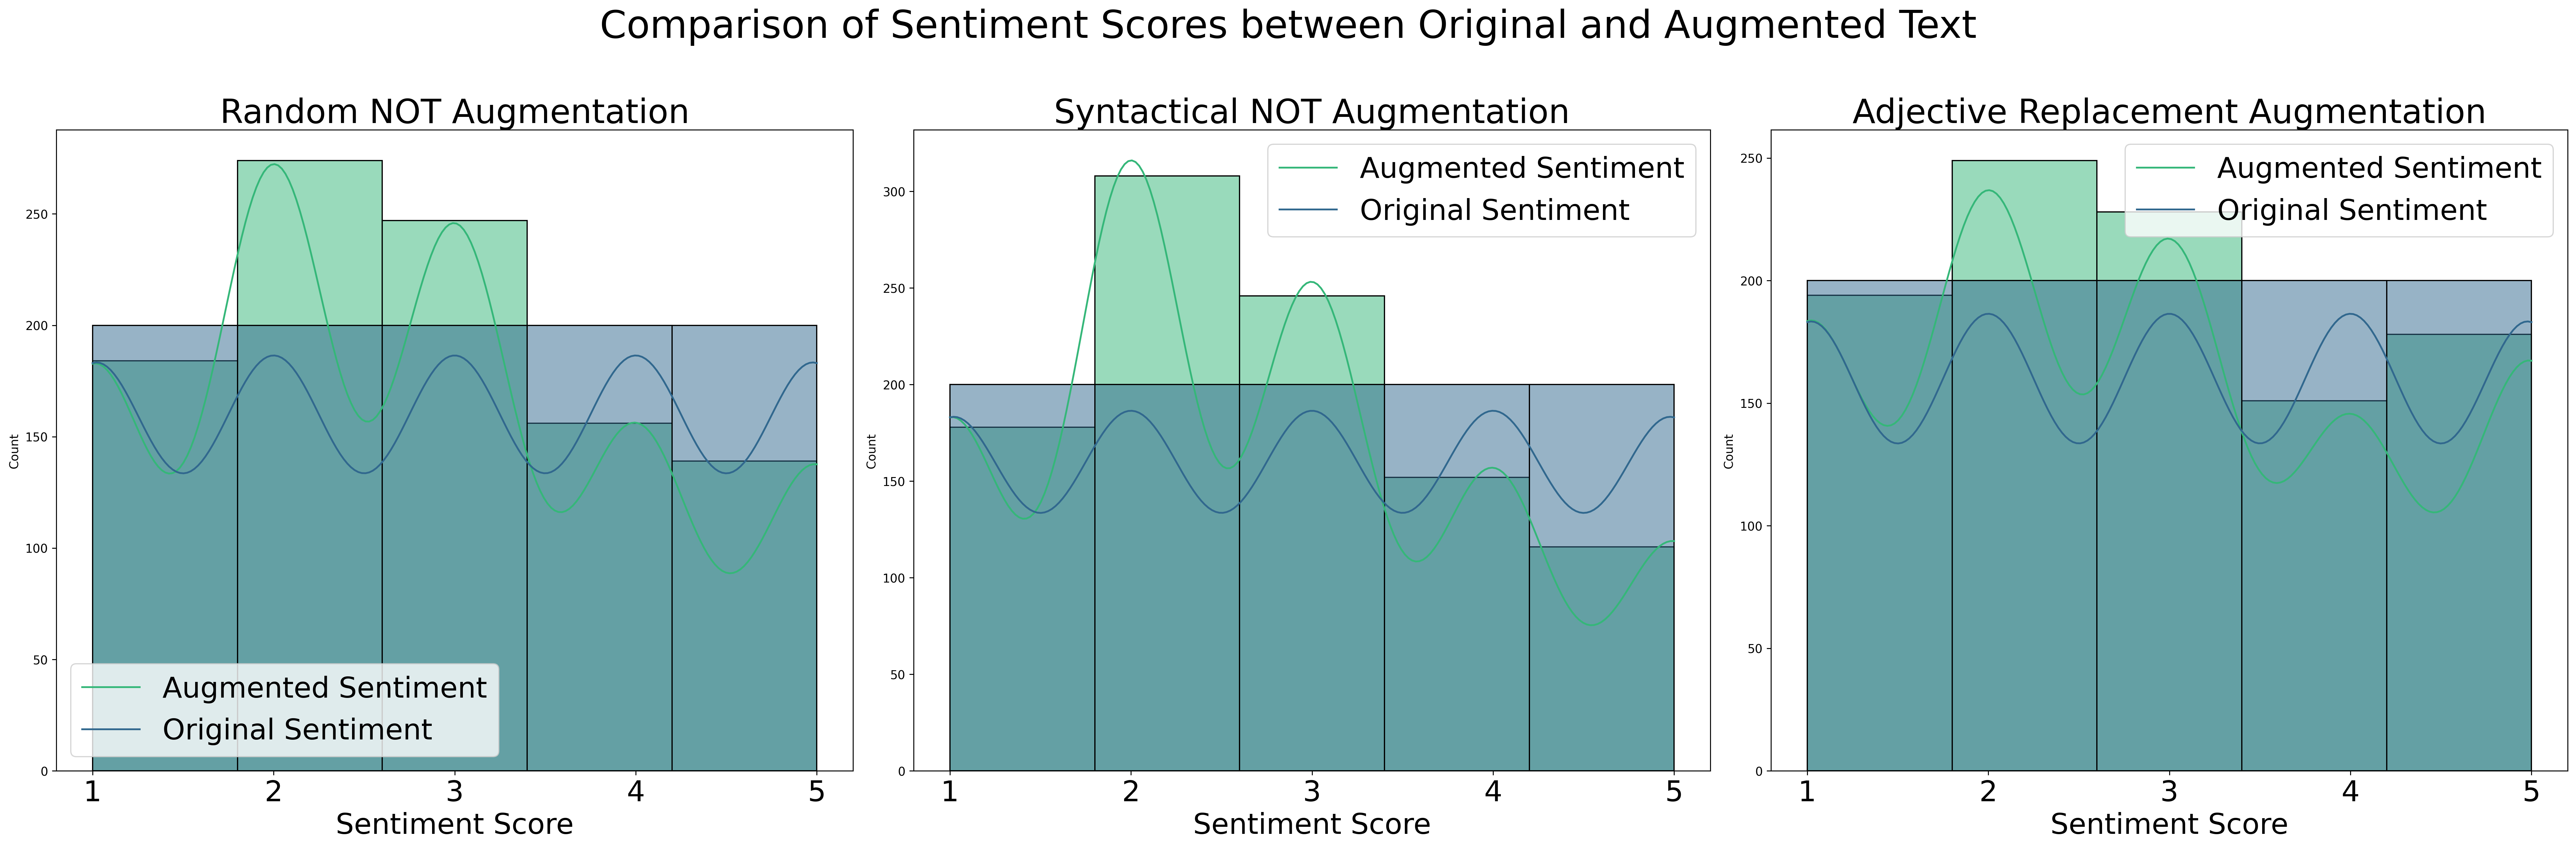

In [10]:
dfs = [df_rnd_not, df_syn_not, df_adj_rpl]
names = ['Random NOT', 'Syntactical NOT', 'Adjective Replacement']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), dpi=280)
axes = axes.flatten()

for i, df in enumerate(dfs):
    ax = axes[i]
    sns.histplot(df[['predicted_sentiment', 'augmented_sentiment']], 
                 kde=True, palette="viridis", bins=5, ax=ax)
    ax.set_xticks(np.arange(1, 5.5, 1))
    ax.set_xticklabels([f'{i}' for i in range(1,6,1)], fontsize=24)
    ax.set_title(f'{names[i]} Augmentation', fontsize=28)
    ax.set_xlabel('Sentiment Score', fontsize=24)
    ax.legend(['Augmented Sentiment', 'Original Sentiment'], fontsize=24)
    
plt.suptitle('Comparison of Sentiment Scores between Original and Augmented Text', fontsize=32)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## sentiment change

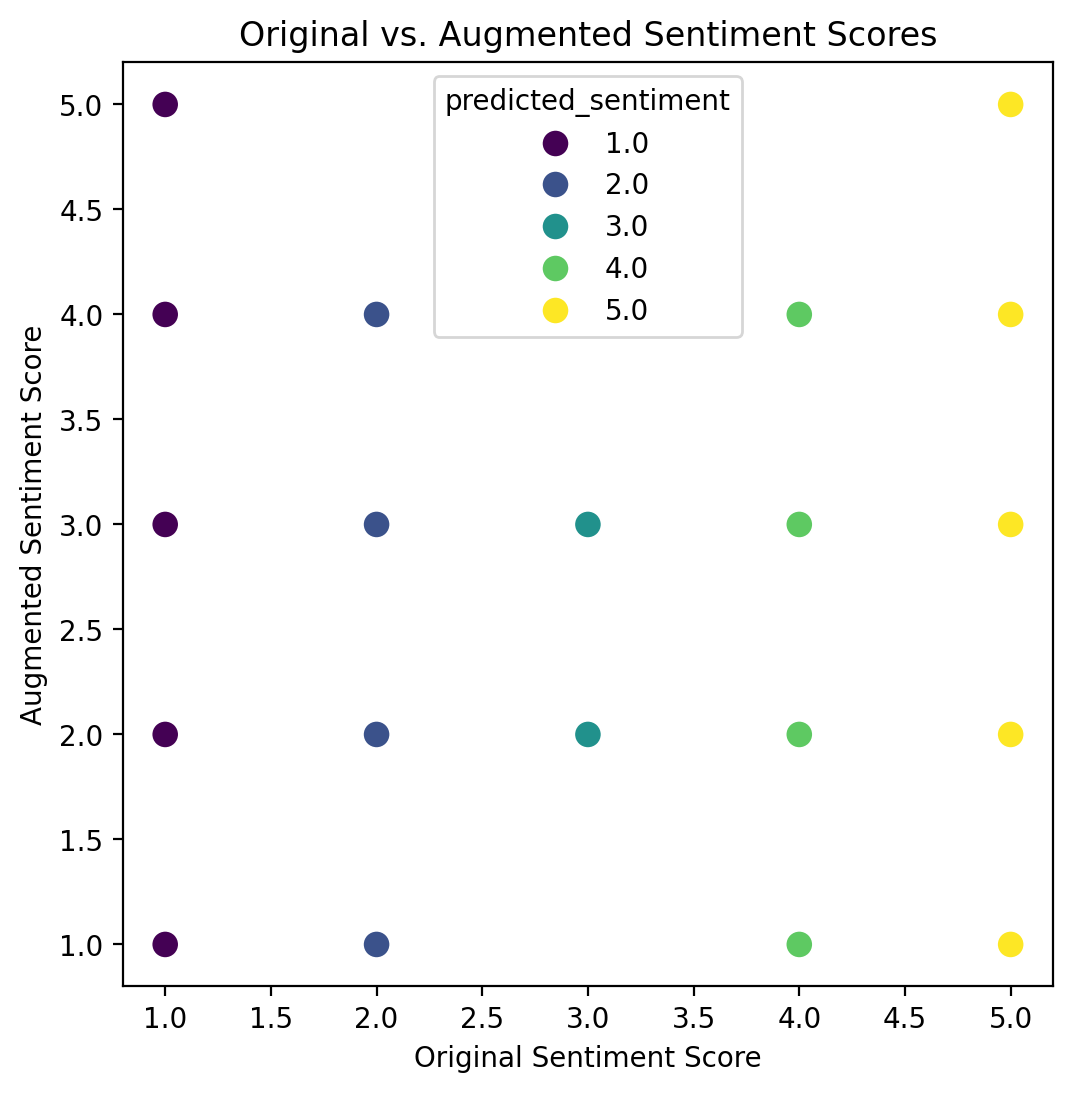

In [8]:
# Scatter plot to show individual comparison
plt.figure(figsize=(6, 6),dpi=200)
sns.scatterplot(x='predicted_sentiment', y='augmented_sentiment', data=df_rnd_not, 
                hue='predicted_sentiment', palette='viridis', s=100)
plt.title('Original vs. Augmented Sentiment Scores')
plt.xlabel('Original Sentiment Score')
plt.ylabel('Augmented Sentiment Score')
plt.show()

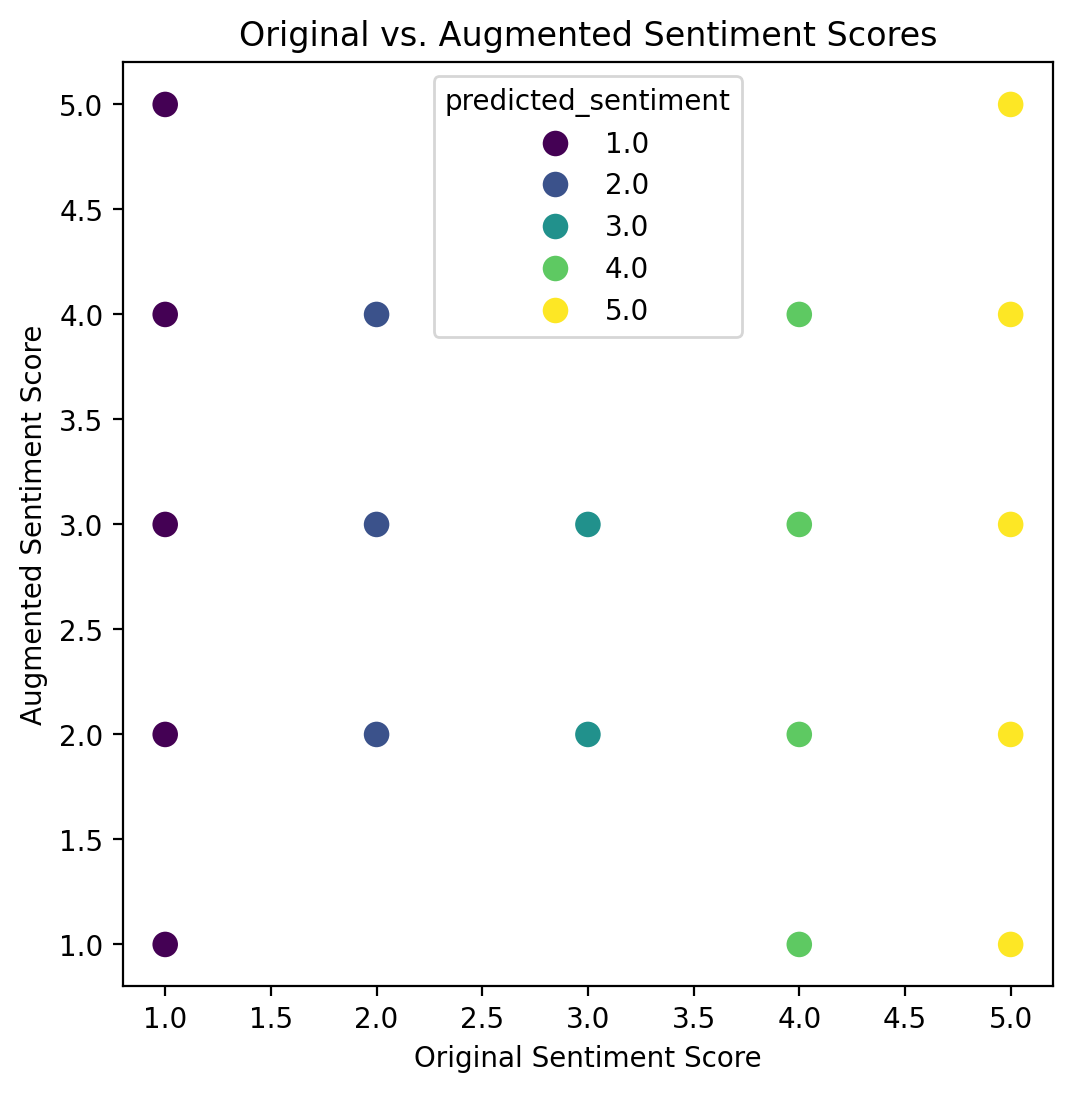

In [9]:
# Scatter plot to show individual comparison
plt.figure(figsize=(6, 6),dpi=200)
sns.scatterplot(x='predicted_sentiment', y='augmented_sentiment', data=df_syn_not, 
                hue='predicted_sentiment', palette='viridis', s=100)
plt.title('Original vs. Augmented Sentiment Scores')
plt.xlabel('Original Sentiment Score')
plt.ylabel('Augmented Sentiment Score')
plt.show()

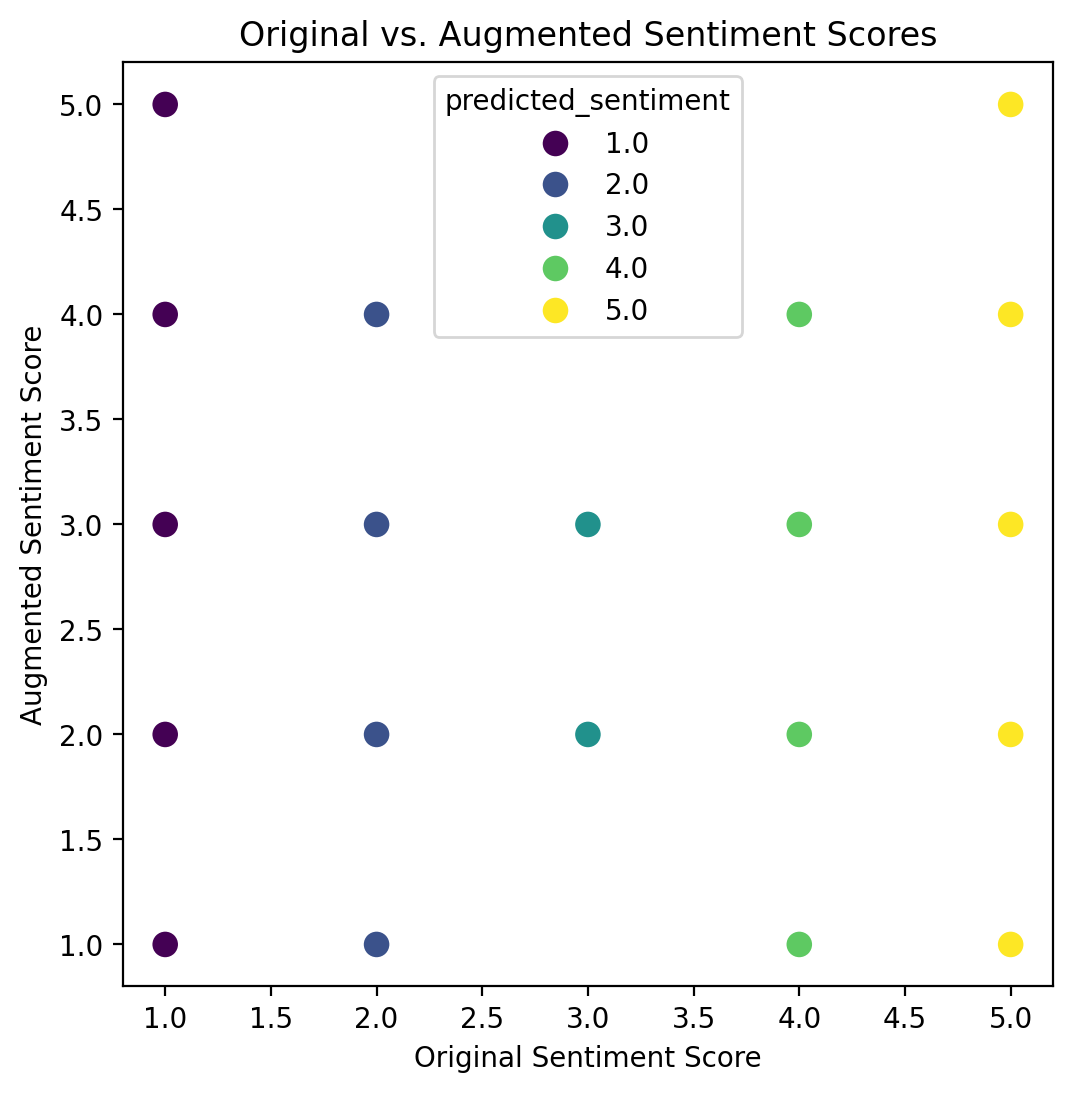

In [10]:
# Scatter plot to show individual comparison
plt.figure(figsize=(6, 6),dpi=200)
sns.scatterplot(x='predicted_sentiment', y='augmented_sentiment', data=df_adj_rpl, 
                hue='predicted_sentiment', palette='viridis', s=100)
plt.title('Original vs. Augmented Sentiment Scores')
plt.xlabel('Original Sentiment Score')
plt.ylabel('Augmented Sentiment Score')
plt.show()

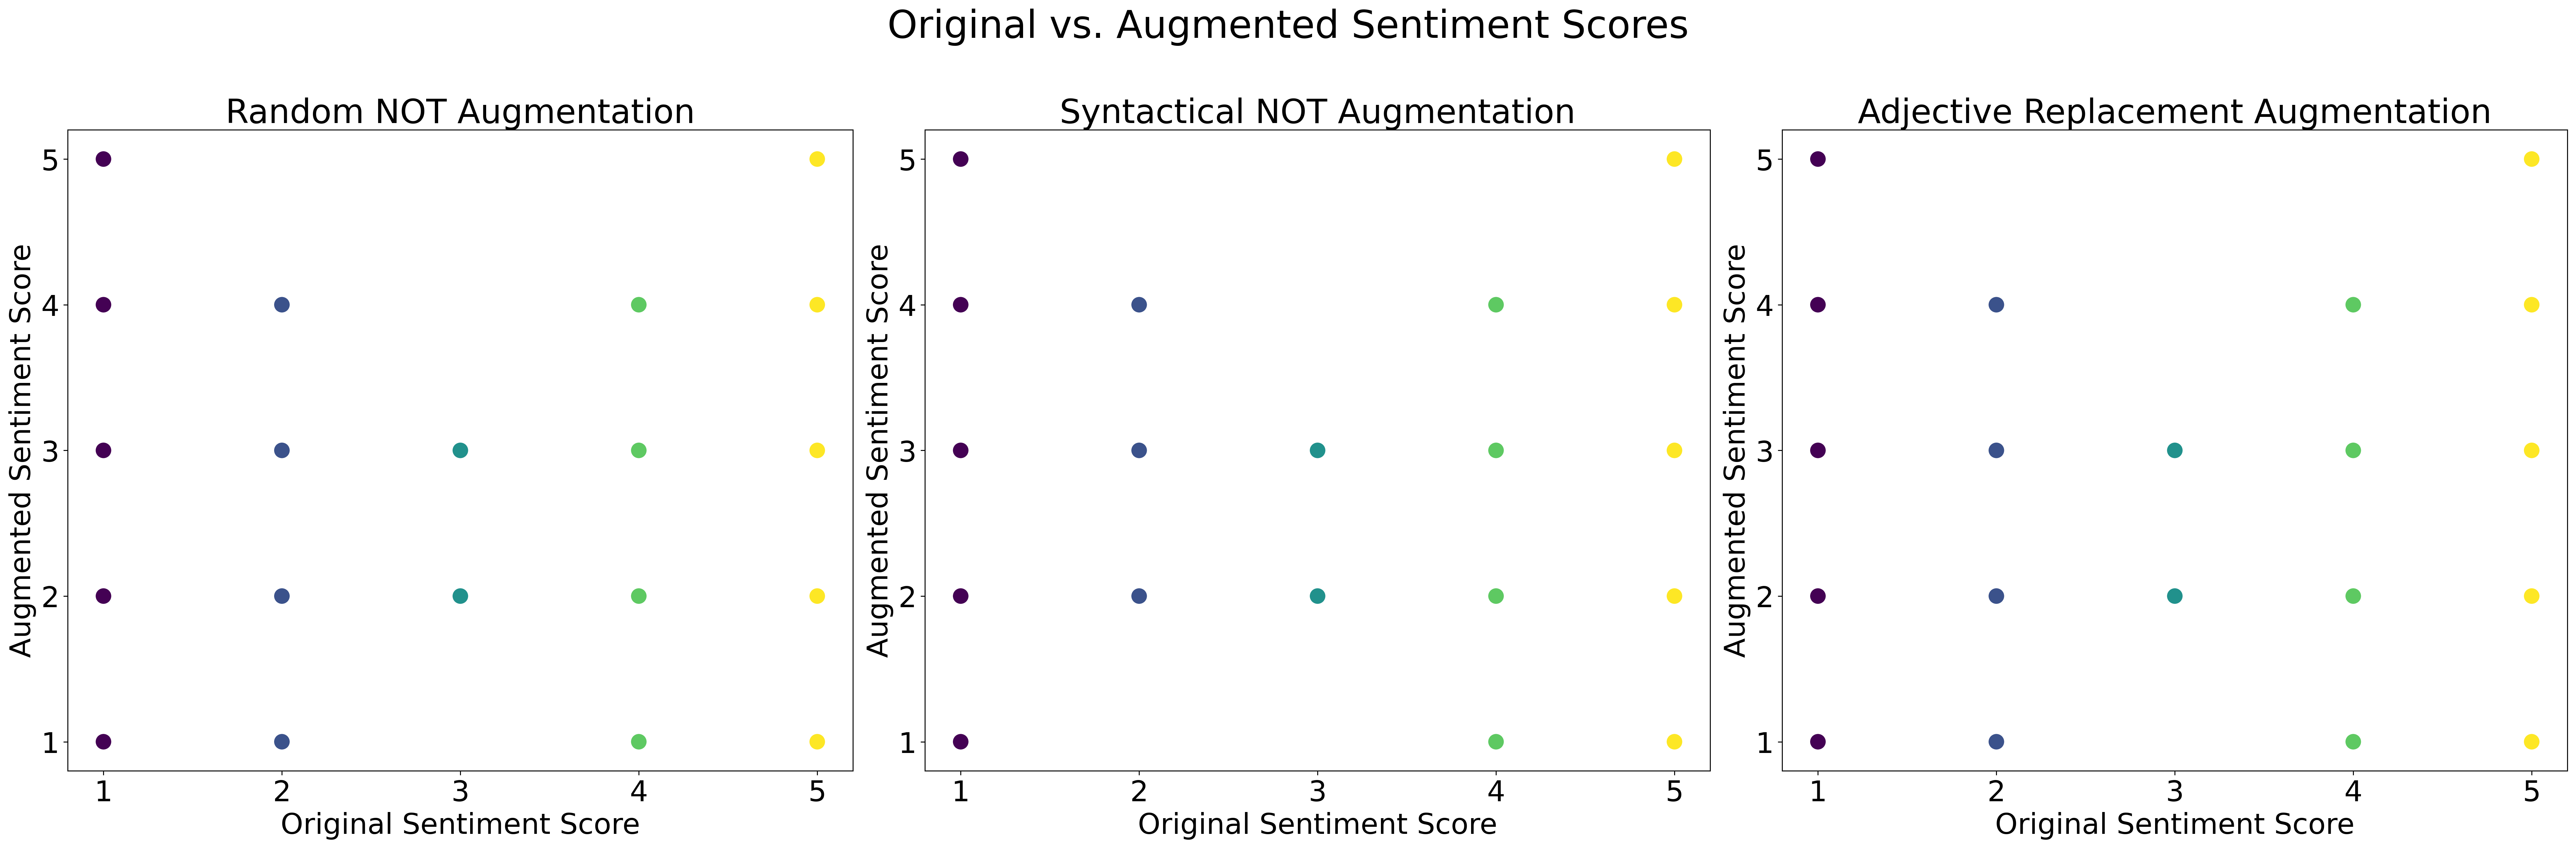

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), dpi=280)

for i, df in enumerate(dfs):
    ax = axes[i]
    sns.scatterplot(x='predicted_sentiment', y='augmented_sentiment', data=df, 
                hue='predicted_sentiment', palette='viridis', s=200,  ax=ax, legend=False)
    plt.title('Original vs. Augmented Sentiment Scores')
    plt.xlabel('Original Sentiment Score')
    plt.ylabel('Augmented Sentiment Score')
    ax.set_xticks(np.arange(1, 5.5, 1))
    ax.set_xticklabels([f'{i}' for i in range(1,6,1)], fontsize=24)
    ax.set_yticks(np.arange(1, 5.5, 1))
    ax.set_yticklabels([f'{i}' for i in range(1,6,1)], fontsize=24)
    ax.set_title(f'{names[i]} Augmentation', fontsize=28)
    ax.set_xlabel('Original Sentiment Score', fontsize=24)
    ax.set_ylabel('Augmented Sentiment Score', fontsize=24)
    
    # # Change the legend font size
    # legend = ax.legend()
    # for text in legend.get_texts():
    #     text.set_fontsize(18)
    
plt.suptitle('Original vs. Augmented Sentiment Scores', fontsize=32)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## some examples

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path+'/retrained_RoBERTa_sentiment_balanced_acc_0.63.pth', map_location='cpu')
model_name = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model.to(device)
rich.print(f"RoBERTa_sentiment on {device} w. balanced dataset.")

RoBERTa_sentiment on cpu w. balanced dataset.

In [13]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

### random

In [15]:
df_diff_sentiment = df_rnd_not[df_rnd_not['predicted_sentiment'] != df_rnd_not['augmented_sentiment']]

# Print the results
for index, row in df_diff_sentiment.iterrows():
    print(f"Original Text: {row['text']}")
    print(f"Original Sentiment: {row['predicted_sentiment']}")
    print(f"Augmented Text: {row['augmented_text']}")
    print(f"Augmented Sentiment: {row['augmented_sentiment']}")
    print("-" * 50)

Original Text: Humanity is doomed
Original Sentiment: 1.0
Augmented Text: Humanity is not doomed
Augmented Sentiment: 4
--------------------------------------------------
Original Text: And she wouldn't give it to him. Poor fellow.
Original Sentiment: 1.0
Augmented Text: And not she wouldn't give it to him. Poor fellow.
Augmented Sentiment: 2
--------------------------------------------------
Original Text: Maybe you’re just extremely boring and bland, and outright refuse to learn to take photos that don’t suck. 
Original Sentiment: 1.0
Augmented Text: Maybe you’re just not extremely boring and bland, and outright refuse to learn to take photos that don’t suck.
Augmented Sentiment: 2
--------------------------------------------------
Original Text: The very worst possible route they could have gone.
Original Sentiment: 1.0
Augmented Text: The not very worst possible route they could have gone.
Augmented Sentiment: 2
--------------------------------------------------
Original Text: Sadl

In [16]:
# Calculate the percentage of changed sentiment scores
num_changed = (df_rnd_not['predicted_sentiment'] != df_rnd_not['augmented_sentiment']).sum()
total_texts = len(df_rnd_not)
percentage_changed = (num_changed / total_texts) * 100

# Calculate the magnitude of the change
df_rnd_not['sentiment_change'] = (df_rnd_not['predicted_sentiment'] - df_rnd_not['augmented_sentiment']).abs()
average_change_magnitude = df_rnd_not['sentiment_change'].mean()

print(f"Percentage of texts with changed sentiment scores: {percentage_changed:.2f}%")
print(f"Average magnitude of sentiment score change: {average_change_magnitude:.2f}")

Percentage of texts with changed sentiment scores: 19.90%
Average magnitude of sentiment score change: 0.32


### syntactical

In [18]:
df_diff_sentiment = df_syn_not[df_syn_not['predicted_sentiment'] != df_syn_not['augmented_sentiment']]

# Print the results
for index, row in df_diff_sentiment.iterrows():
    print(f"Original Text: {row['text']}")
    print(f"Original Sentiment: {row['predicted_sentiment']}")
    print(f"Augmented Text: {row['augmented_text']}")
    print(f"Augmented Sentiment: {row['augmented_sentiment']}")
    print("-" * 50)

Original Text: Oh [NAME] that was horrible
Original Sentiment: 1.0
Augmented Text: Oh [ NAME ] that was not horrible
Augmented Sentiment: 4
--------------------------------------------------
Original Text: Got one, it's still bad dude
Original Sentiment: 1.0
Augmented Text: Got one , it 's not still bad dude
Augmented Sentiment: 4
--------------------------------------------------
Original Text: They're cowards.
Original Sentiment: 1.0
Augmented Text: They 're not cowards .
Augmented Sentiment: 2
--------------------------------------------------
Original Text: I have endured worse.
Original Sentiment: 1.0
Augmented Text: I have not endured worse .
Augmented Sentiment: 2
--------------------------------------------------
Original Text: Humanity is doomed
Original Sentiment: 1.0
Augmented Text: Humanity is not doomed
Augmented Sentiment: 4
--------------------------------------------------
Original Text: And she wouldn't give it to him. Poor fellow.
Original Sentiment: 1.0
Augmented Tex

In [19]:
# Calculate the percentage of changed sentiment scores
num_changed = (df_syn_not['predicted_sentiment'] != df_syn_not['augmented_sentiment']).sum()
total_texts = len(df_syn_not)
percentage_changed = (num_changed / total_texts) * 100

# Calculate the magnitude of the change
df_syn_not['sentiment_change'] = (df_syn_not['predicted_sentiment'] - df_syn_not['augmented_sentiment']).abs()
average_change_magnitude = df_syn_not['sentiment_change'].mean()

print(f"Percentage of texts with changed sentiment scores: {percentage_changed:.2f}%")
print(f"Average magnitude of sentiment score change: {average_change_magnitude:.2f}")

Percentage of texts with changed sentiment scores: 25.00%
Average magnitude of sentiment score change: 0.45


### adjective replace

In [21]:
df_diff_sentiment = df_adj_rpl[df_syn_not['predicted_sentiment'] != df_adj_rpl['augmented_sentiment']]

# Print the results
for index, row in df_diff_sentiment.iterrows():
    print(f"Original Text: {row['text']}")
    print(f"Original Sentiment: {row['predicted_sentiment']}")
    print(f"Augmented Text: {row['augmented_text']}")
    print(f"Augmented Sentiment: {row['augmented_sentiment']}")
    print("-" * 50)

Original Text: Got one, it's still bad dude
Original Sentiment: 1.0
Augmented Text: Got one, it's still unregretful dude
Augmented Sentiment: 2
--------------------------------------------------
Original Text: And she wouldn't give it to him. Poor fellow.
Original Sentiment: 1.0
Augmented Text: And she wouldn't give it to him. rich fellow.
Augmented Sentiment: 2
--------------------------------------------------
Original Text: Middle Eastern here and watching this team lose due to silly mistakes at 3-4 am kills me
Original Sentiment: 1.0
Augmented Text: Middle Eastern here and watching this team lose undue to silly mistakes at 3-4 am kills me
Augmented Sentiment: 2
--------------------------------------------------
Original Text: Omg enough of all the damn hashtags, it’s not 2016 anymore
Original Sentiment: 1.0
Augmented Text: Omg enough of all the bless hashtags, it’s not 2016 anymore
Augmented Sentiment: 2
--------------------------------------------------
Original Text: I have yet t

In [20]:
# Calculate the percentage of changed sentiment scores
num_changed = (df_adj_rpl['predicted_sentiment'] != df_adj_rpl['augmented_sentiment']).sum()
total_texts = len(df_adj_rpl)
percentage_changed = (num_changed / total_texts) * 100

# Calculate the magnitude of the change
df_adj_rpl['sentiment_change'] = (df_adj_rpl['predicted_sentiment'] - df_adj_rpl['augmented_sentiment']).abs()
average_change_magnitude = df_adj_rpl['sentiment_change'].mean()

print(f"Percentage of texts with changed sentiment scores: {percentage_changed:.2f}%")
print(f"Average magnitude of sentiment score change: {average_change_magnitude:.2f}")

Percentage of texts with changed sentiment scores: 15.60%
Average magnitude of sentiment score change: 0.31
